# Module 05: Activation Functions

**The Key to Non-Linearity**

---

## Objectives

By the end of this notebook, you will:
- Understand why activation functions are essential
- Master sigmoid, tanh, ReLU, and their variants
- Know the problems with each activation (vanishing gradients, dying ReLU)
- Understand softmax for classification
- Know when to use which activation function

**Prerequisites:** [Module 04 - The Neuron](../04_the_neuron/04_neuron.ipynb)

---

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

---

# Part 1: Why Non-Linearity?

---

## 1.1 The Problem with Linear Functions

Without activation functions, a neural network is just a linear transformation.

**Proof:** Consider a 2-layer network without activations:
- Layer 1: $h = W_1 x + b_1$
- Layer 2: $y = W_2 h + b_2 = W_2 (W_1 x + b_1) + b_2$

Simplifying:
$$y = W_2 W_1 x + W_2 b_1 + b_2 = W' x + b'$$

This is just another linear function! No matter how many layers we add, the result is always linear.

In [2]:
# Demonstration: Stacking linear layers without activation
torch.manual_seed(42)

# 3-layer "network" without activations
layer1 = nn.Linear(2, 4)
layer2 = nn.Linear(4, 4)
layer3 = nn.Linear(4, 1)

# The effective transformation
W_combined = layer3.weight @ layer2.weight @ layer1.weight
print(f"Layer 1 weight shape: {layer1.weight.shape}")
print(f"Layer 2 weight shape: {layer2.weight.shape}")
print(f"Layer 3 weight shape: {layer3.weight.shape}")
print(f"\nCombined weight shape: {W_combined.shape}")
print("\nA 3-layer network without activations = single linear transform!")

Layer 1 weight shape: torch.Size([4, 2])
Layer 2 weight shape: torch.Size([4, 4])
Layer 3 weight shape: torch.Size([1, 4])

Combined weight shape: torch.Size([1, 2])

A 3-layer network without activations = single linear transform!


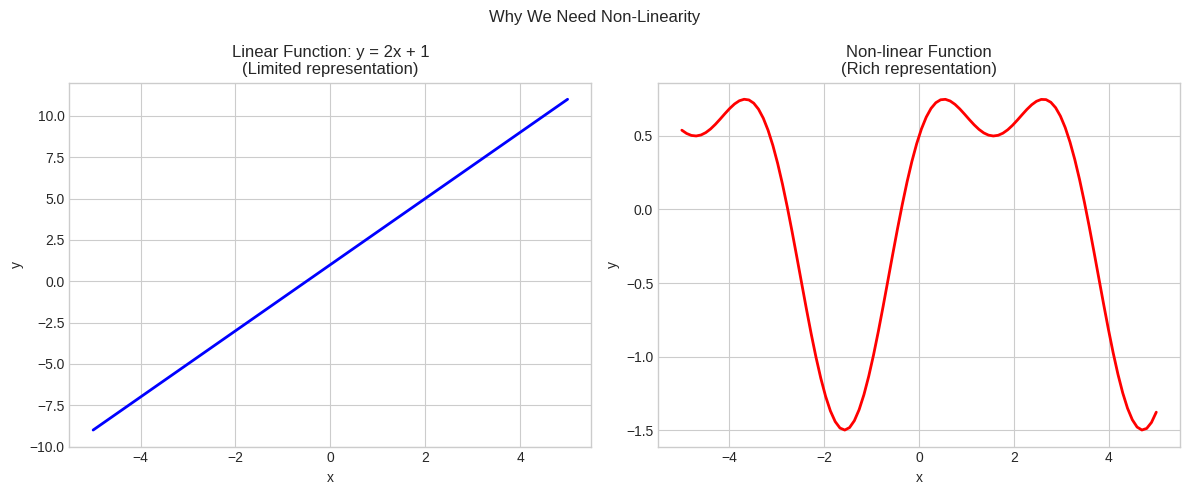

In [3]:
# Visualization: Linear vs Non-linear
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Linear function
x = np.linspace(-5, 5, 100)
y_linear = 2 * x + 1

axes[0].plot(x, y_linear, 'b-', linewidth=2)
axes[0].set_title('Linear Function: y = 2x + 1\n(Limited representation)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Non-linear function (what we can learn with activations)
y_nonlinear = np.sin(x) + 0.5 * np.cos(2*x)
axes[1].plot(x, y_nonlinear, 'r-', linewidth=2)
axes[1].set_title('Non-linear Function\n(Rich representation)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

plt.suptitle('Why We Need Non-Linearity', fontsize=12)
plt.tight_layout()
plt.show()

## 1.2 What Activation Functions Do

Activation functions:
1. **Introduce non-linearity** - Allow learning complex patterns
2. **Control output range** - Bound outputs to useful ranges
3. **Enable gradient flow** - Their derivatives are used in backpropagation

---

# Part 2: Sigmoid

---

## 2.1 Definition and Properties

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

**Properties:**
- Output range: (0, 1)
- Monotonically increasing
- Differentiable everywhere
- $\sigma(0) = 0.5$

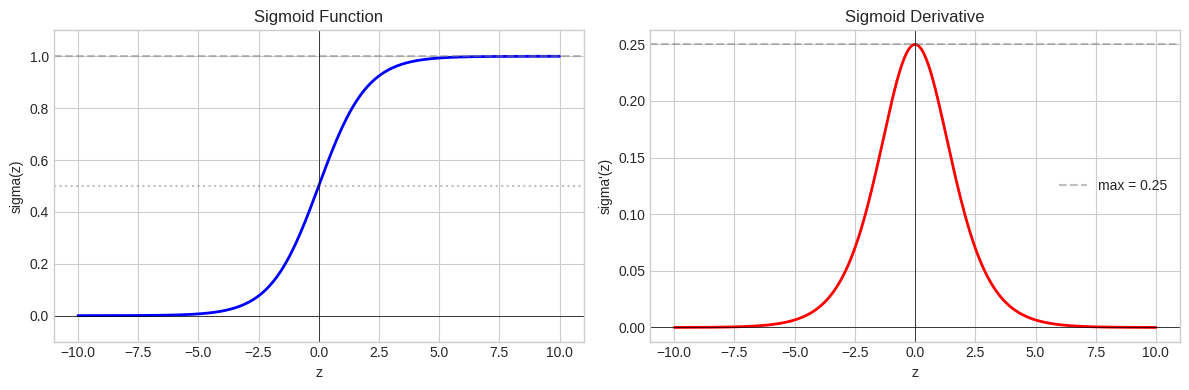

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

# Plot sigmoid and its derivative
z = np.linspace(-10, 10, 200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Sigmoid
axes[0].plot(z, sigmoid(z), 'b-', linewidth=2)
axes[0].axhline(y=0, color='k', linewidth=0.5)
axes[0].axhline(y=1, color='gray', linestyle='--', alpha=0.5)
axes[0].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].axvline(x=0, color='k', linewidth=0.5)
axes[0].set_xlabel('z')
axes[0].set_ylabel('sigma(z)')
axes[0].set_title('Sigmoid Function')
axes[0].set_ylim(-0.1, 1.1)

# Derivative
axes[1].plot(z, sigmoid_derivative(z), 'r-', linewidth=2)
axes[1].axhline(y=0, color='k', linewidth=0.5)
axes[1].axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, label='max = 0.25')
axes[1].axvline(x=0, color='k', linewidth=0.5)
axes[1].set_xlabel('z')
axes[1].set_ylabel("sigma'(z)")
axes[1].set_title('Sigmoid Derivative')
axes[1].legend()

plt.tight_layout()
plt.show()

## 2.2 The Vanishing Gradient Problem

Notice the derivative:
$$\sigma'(z) = \sigma(z)(1 - \sigma(z))$$

**Maximum value is 0.25** (when z=0). This causes problems:
- In backprop, we multiply many derivatives
- If each is at most 0.25, the gradient shrinks exponentially
- Deep layers receive almost zero gradient

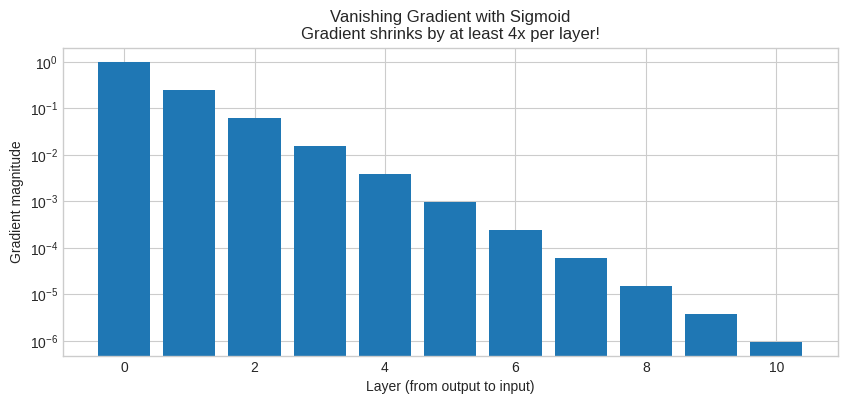

After 10 layers, gradient is multiplied by at most: 9.54e-07


In [5]:
# Demonstration: Gradient shrinking through layers
n_layers = 10
gradient = 1.0  # Initial gradient
max_derivative = 0.25  # Maximum sigmoid derivative

gradients = [gradient]
for _ in range(n_layers):
    gradient *= max_derivative
    gradients.append(gradient)

plt.figure(figsize=(10, 4))
plt.bar(range(n_layers + 1), gradients)
plt.xlabel('Layer (from output to input)')
plt.ylabel('Gradient magnitude')
plt.title('Vanishing Gradient with Sigmoid\nGradient shrinks by at least 4x per layer!')
plt.yscale('log')
plt.grid(True)
plt.show()

print(f"After 10 layers, gradient is multiplied by at most: {0.25**10:.2e}")

## 2.3 Sigmoid is Not Zero-Centered

Sigmoid outputs are always positive (0 to 1). This causes:
- All gradients for weights have the same sign
- Updates can only be all positive or all negative
- Leads to "zig-zagging" in optimization

## 2.4 When to Use Sigmoid

**Use sigmoid:**
- Output layer for **binary classification** (probability between 0 and 1)
- Gates in LSTM/GRU (controls information flow)

**Avoid sigmoid:**
- Hidden layers (use ReLU instead)
- Deep networks (vanishing gradients)

---

# Part 3: Tanh (Hyperbolic Tangent)

---

## 3.1 Definition and Properties

$$\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}} = 2\sigma(2z) - 1$$

**Properties:**
- Output range: (-1, 1)
- **Zero-centered** (unlike sigmoid)
- $\tanh(0) = 0$

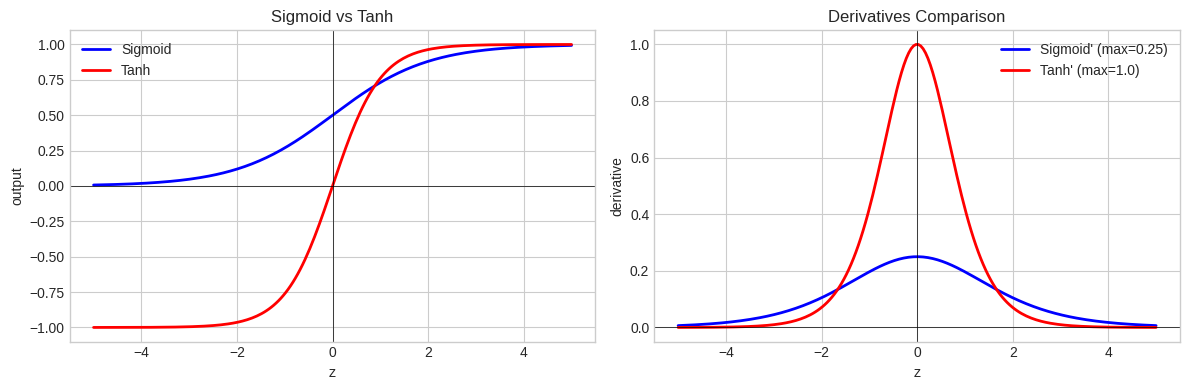

In [6]:
def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return 1 - np.tanh(z)**2

# Compare sigmoid and tanh
z = np.linspace(-5, 5, 200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Functions
axes[0].plot(z, sigmoid(z), 'b-', linewidth=2, label='Sigmoid')
axes[0].plot(z, tanh(z), 'r-', linewidth=2, label='Tanh')
axes[0].axhline(y=0, color='k', linewidth=0.5)
axes[0].axvline(x=0, color='k', linewidth=0.5)
axes[0].set_xlabel('z')
axes[0].set_ylabel('output')
axes[0].set_title('Sigmoid vs Tanh')
axes[0].legend()

# Derivatives
axes[1].plot(z, sigmoid_derivative(z), 'b-', linewidth=2, label="Sigmoid' (max=0.25)")
axes[1].plot(z, tanh_derivative(z), 'r-', linewidth=2, label="Tanh' (max=1.0)")
axes[1].axhline(y=0, color='k', linewidth=0.5)
axes[1].axvline(x=0, color='k', linewidth=0.5)
axes[1].set_xlabel('z')
axes[1].set_ylabel('derivative')
axes[1].set_title('Derivatives Comparison')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.2 Tanh vs Sigmoid

| Property | Sigmoid | Tanh |
|----------|---------|------|
| Range | (0, 1) | (-1, 1) |
| Zero-centered | No | Yes |
| Max derivative | 0.25 | 1.0 |
| Vanishing gradient | Severe | Less severe |

Tanh is generally preferred over sigmoid for hidden layers because it's zero-centered and has stronger gradients. But both still suffer from vanishing gradients in deep networks.

---

# Part 4: ReLU (Rectified Linear Unit)

---

## 4.1 Definition and Properties

$$\text{ReLU}(z) = \max(0, z)$$

**Properties:**
- Output range: [0, infinity)
- Non-saturating for positive values
- Computationally efficient
- Sparse activation (many zeros)

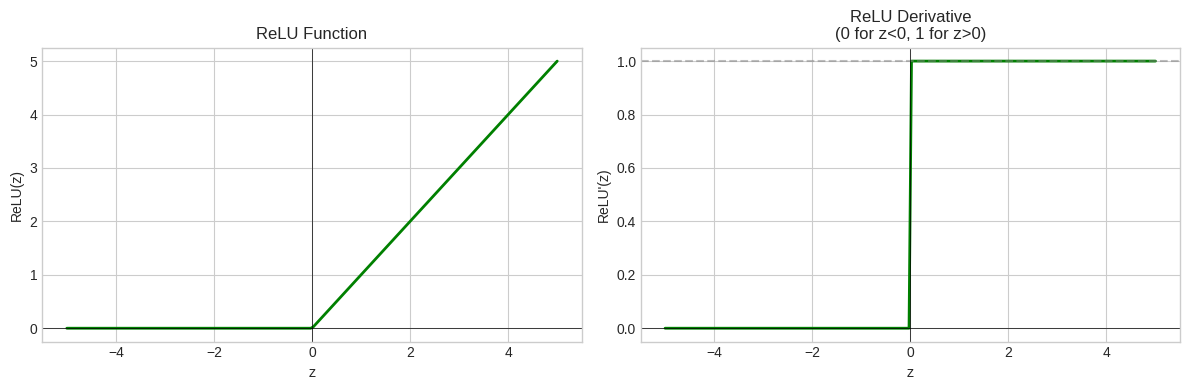

In [7]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

# Plot ReLU
z = np.linspace(-5, 5, 200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ReLU
axes[0].plot(z, relu(z), 'g-', linewidth=2)
axes[0].axhline(y=0, color='k', linewidth=0.5)
axes[0].axvline(x=0, color='k', linewidth=0.5)
axes[0].set_xlabel('z')
axes[0].set_ylabel('ReLU(z)')
axes[0].set_title('ReLU Function')

# Derivative
axes[1].plot(z, relu_derivative(z), 'g-', linewidth=2)
axes[1].axhline(y=0, color='k', linewidth=0.5)
axes[1].axhline(y=1, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(x=0, color='k', linewidth=0.5)
axes[1].set_xlabel('z')
axes[1].set_ylabel("ReLU'(z)")
axes[1].set_title('ReLU Derivative\n(0 for z<0, 1 for z>0)')

plt.tight_layout()
plt.show()

## 4.2 Why ReLU is Popular

1. **No vanishing gradient (for positive values)**
   - Derivative is 1 for z > 0
   - Gradients flow unchanged

2. **Computationally efficient**
   - Just a threshold (no exp)
   - Fast forward and backward pass

3. **Sparse activations**
   - Many neurons output 0
   - Acts as regularization

## 4.3 The Dying ReLU Problem

If a neuron's inputs always yield z < 0:
- Output is always 0
- Gradient is always 0
- The neuron "dies" - never learns again

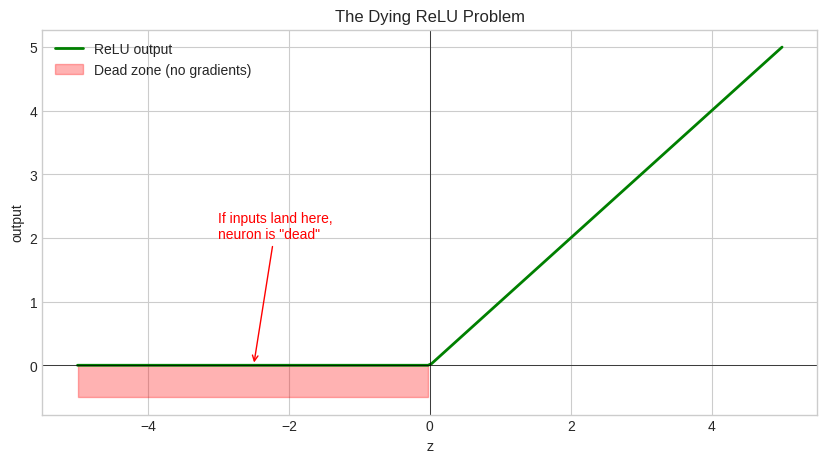

In [8]:
# Demonstration: Dying ReLU
fig, ax = plt.subplots(figsize=(10, 5))

z = np.linspace(-5, 5, 200)

ax.plot(z, relu(z), 'g-', linewidth=2, label='ReLU output')
ax.fill_between(z[z < 0], 0, -0.5, alpha=0.3, color='red', label='Dead zone (no gradients)')
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)

ax.annotate('If inputs land here,\nneuron is "dead"',
            xy=(-2.5, 0), xytext=(-3, 2),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red')

ax.set_xlabel('z')
ax.set_ylabel('output')
ax.set_title('The Dying ReLU Problem')
ax.legend()
plt.show()

---

# Part 5: ReLU Variants

---

## 5.1 Leaky ReLU

$$\text{LeakyReLU}(z) = \begin{cases} z & \text{if } z > 0 \\ \alpha z & \text{if } z \leq 0 \end{cases}$$

Typically $\alpha = 0.01$. Allows small gradient when z < 0.

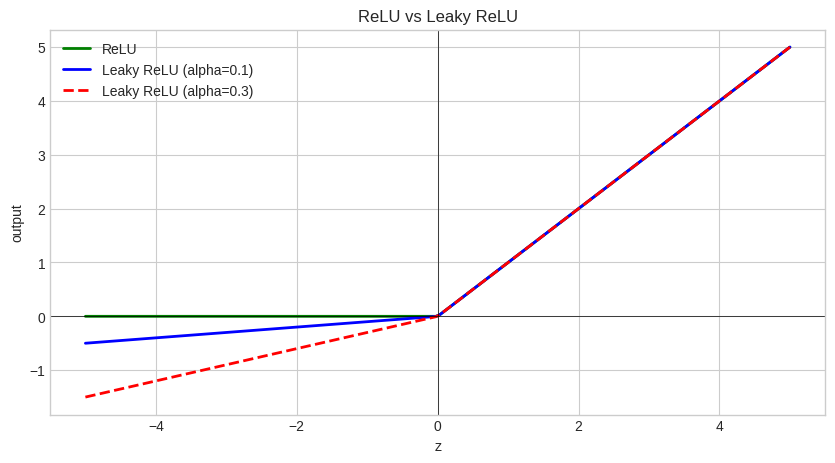

In [9]:
def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

# Compare ReLU variants
z = np.linspace(-5, 5, 200)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(z, relu(z), 'g-', linewidth=2, label='ReLU')
ax.plot(z, leaky_relu(z, 0.1), 'b-', linewidth=2, label='Leaky ReLU (alpha=0.1)')
ax.plot(z, leaky_relu(z, 0.3), 'r--', linewidth=2, label='Leaky ReLU (alpha=0.3)')

ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('z')
ax.set_ylabel('output')
ax.set_title('ReLU vs Leaky ReLU')
ax.legend()
plt.show()

## 5.2 ELU (Exponential Linear Unit)

$$\text{ELU}(z) = \begin{cases} z & \text{if } z > 0 \\ \alpha (e^z - 1) & \text{if } z \leq 0 \end{cases}$$

- Smooth curve for negative values
- Mean activations closer to zero

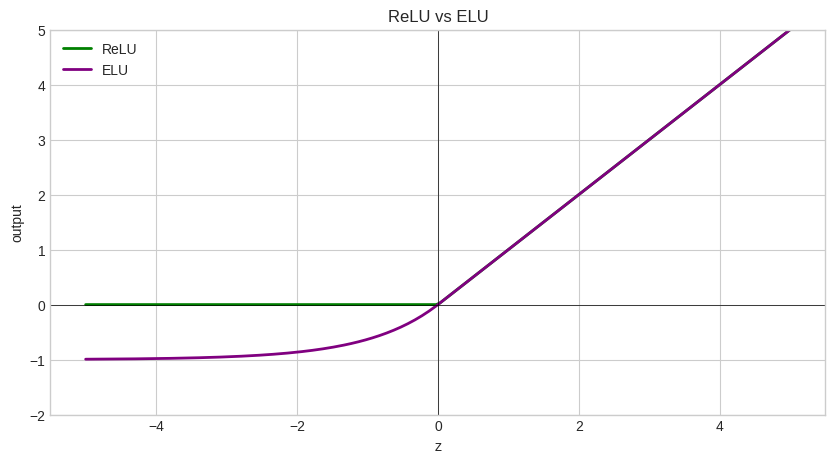

In [10]:
def elu(z, alpha=1.0):
    return np.where(z > 0, z, alpha * (np.exp(z) - 1))

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(z, relu(z), 'g-', linewidth=2, label='ReLU')
ax.plot(z, elu(z), 'purple', linewidth=2, label='ELU')

ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('z')
ax.set_ylabel('output')
ax.set_title('ReLU vs ELU')
ax.legend()
ax.set_ylim(-2, 5)
plt.show()

## 5.3 GELU (Gaussian Error Linear Unit)

$$\text{GELU}(z) = z \cdot \Phi(z)$$

Where $\Phi$ is the CDF of standard normal distribution.

- Used in BERT, GPT, and modern transformers
- Smooth approximation of ReLU
- Allows small negative values

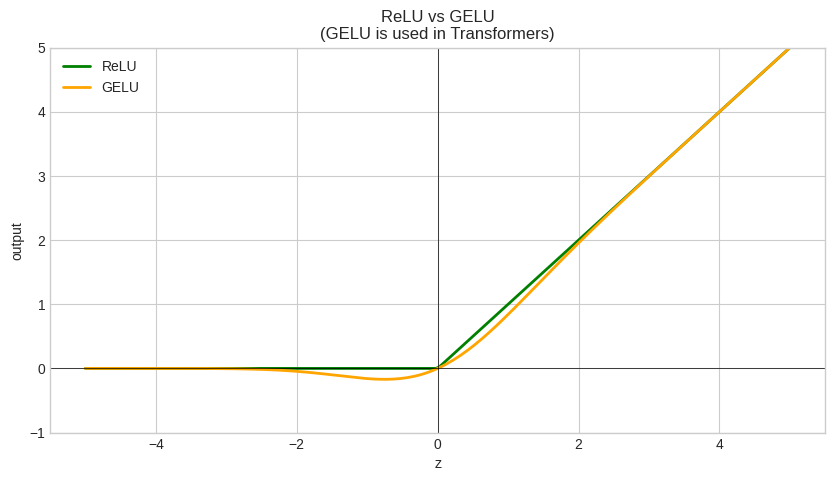

In [11]:
from scipy.special import erf

def gelu(z):
    return 0.5 * z * (1 + erf(z / np.sqrt(2)))

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(z, relu(z), 'g-', linewidth=2, label='ReLU')
ax.plot(z, gelu(z), 'orange', linewidth=2, label='GELU')

ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('z')
ax.set_ylabel('output')
ax.set_title('ReLU vs GELU\n(GELU is used in Transformers)')
ax.legend()
ax.set_ylim(-1, 5)
plt.show()

## 5.4 Swish

$$\text{Swish}(z) = z \cdot \sigma(z) = \frac{z}{1 + e^{-z}}$$

- Self-gated activation
- Smooth and non-monotonic
- Used in EfficientNet and some modern architectures

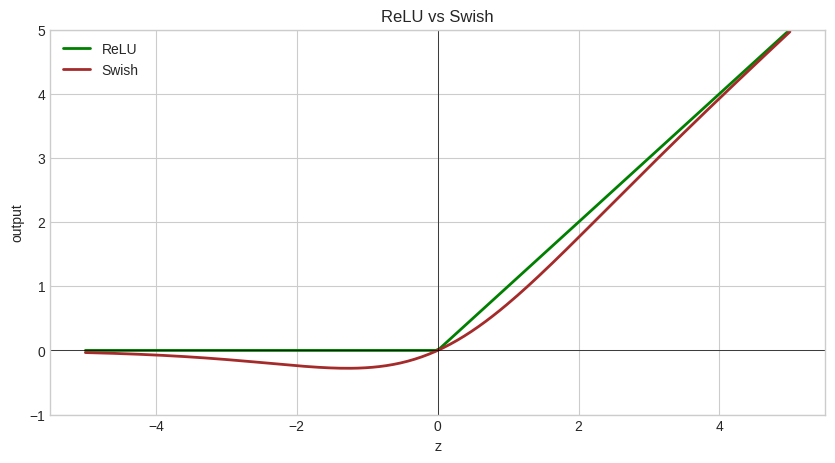

In [12]:
def swish(z):
    return z * sigmoid(z)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(z, relu(z), 'g-', linewidth=2, label='ReLU')
ax.plot(z, swish(z), 'brown', linewidth=2, label='Swish')

ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('z')
ax.set_ylabel('output')
ax.set_title('ReLU vs Swish')
ax.legend()
ax.set_ylim(-1, 5)
plt.show()

## 5.5 Comparison Summary

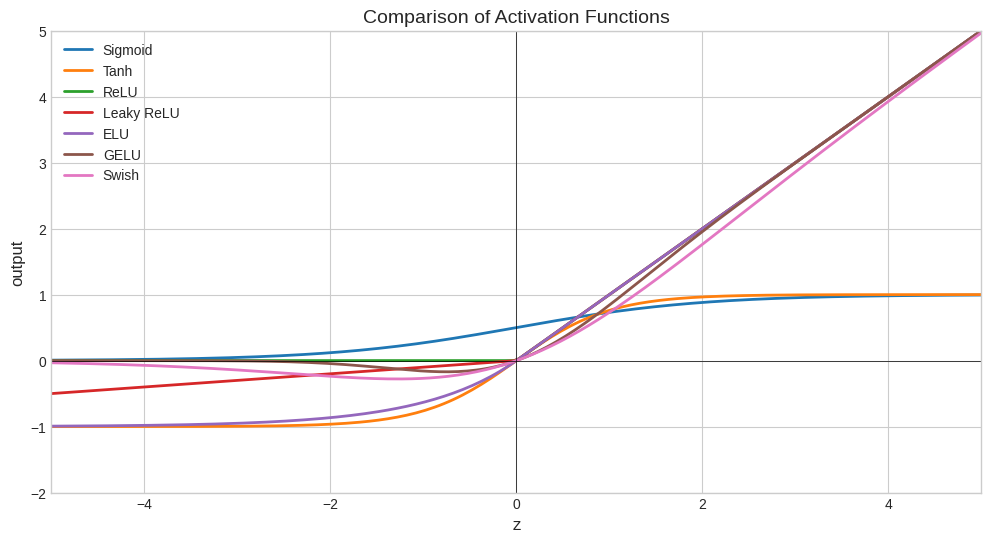

In [13]:
# All activations together
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(z, sigmoid(z), linewidth=2, label='Sigmoid')
ax.plot(z, tanh(z), linewidth=2, label='Tanh')
ax.plot(z, relu(z), linewidth=2, label='ReLU')
ax.plot(z, leaky_relu(z, 0.1), linewidth=2, label='Leaky ReLU')
ax.plot(z, elu(z), linewidth=2, label='ELU')
ax.plot(z, gelu(z), linewidth=2, label='GELU')
ax.plot(z, swish(z), linewidth=2, label='Swish')

ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('z', fontsize=12)
ax.set_ylabel('output', fontsize=12)
ax.set_title('Comparison of Activation Functions', fontsize=14)
ax.legend(loc='upper left')
ax.set_xlim(-5, 5)
ax.set_ylim(-2, 5)
plt.show()

---

# Part 6: Softmax

---

## 6.1 Definition and Purpose

For multi-class classification, we need outputs that:
1. Are between 0 and 1 (probabilities)
2. Sum to 1 (probability distribution)

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

In [14]:
def softmax(z):
    exp_z = np.exp(z - np.max(z))  # Subtract max for numerical stability
    return exp_z / np.sum(exp_z)

# Example: 3-class classification
logits = np.array([2.0, 1.0, 0.5])
probs = softmax(logits)

print(f"Logits (raw scores): {logits}")
print(f"Probabilities: {probs}")
print(f"Sum of probabilities: {probs.sum():.4f}")

Logits (raw scores): [2.  1.  0.5]
Probabilities: [0.62853172 0.2312239  0.14024438]
Sum of probabilities: 1.0000


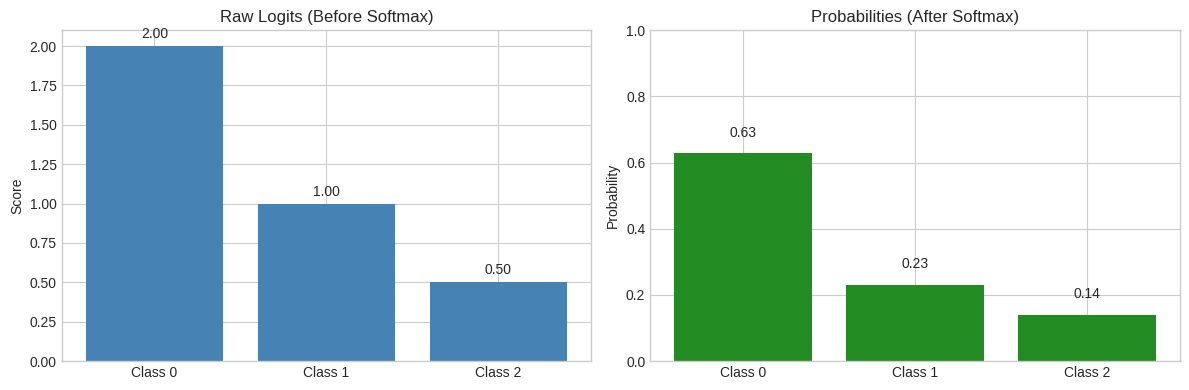

In [15]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

classes = ['Class 0', 'Class 1', 'Class 2']

# Logits
axes[0].bar(classes, logits, color='steelblue')
axes[0].set_ylabel('Score')
axes[0].set_title('Raw Logits (Before Softmax)')

# Probabilities
axes[1].bar(classes, probs, color='forestgreen')
axes[1].set_ylabel('Probability')
axes[1].set_title('Probabilities (After Softmax)')
axes[1].set_ylim(0, 1)

for ax, vals in zip(axes, [logits, probs]):
    for i, v in enumerate(vals):
        ax.text(i, v + 0.05, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

## 6.2 Temperature in Softmax

$$\text{softmax}(z_i, T) = \frac{e^{z_i/T}}{\sum_{j=1}^{K} e^{z_j/T}}$$

- **High T**: Softer distribution (more uniform)
- **Low T**: Sharper distribution (more confident)
- **T -> 0**: Becomes argmax

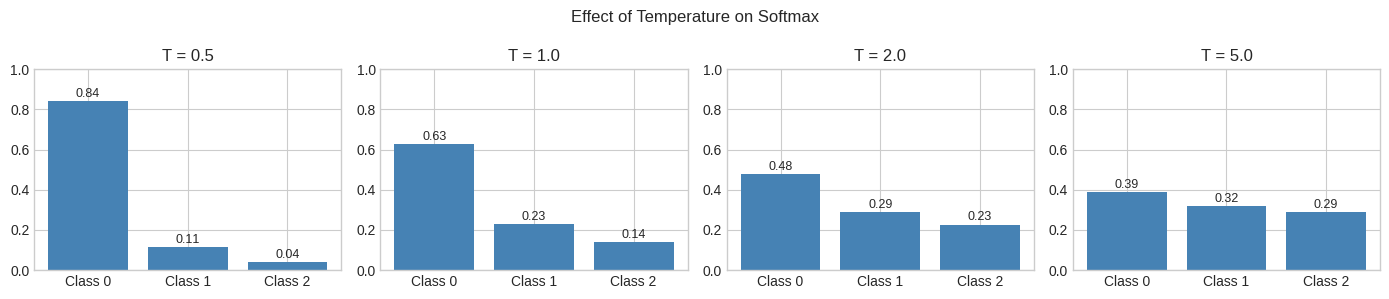

In [16]:
def softmax_temp(z, T=1.0):
    z_scaled = z / T
    exp_z = np.exp(z_scaled - np.max(z_scaled))
    return exp_z / np.sum(exp_z)

logits = np.array([2.0, 1.0, 0.5])
temperatures = [0.5, 1.0, 2.0, 5.0]

fig, axes = plt.subplots(1, 4, figsize=(14, 3))

for ax, T in zip(axes, temperatures):
    probs = softmax_temp(logits, T)
    ax.bar(classes, probs, color='steelblue')
    ax.set_ylim(0, 1)
    ax.set_title(f'T = {T}')
    for i, v in enumerate(probs):
        ax.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)

plt.suptitle('Effect of Temperature on Softmax', fontsize=12)
plt.tight_layout()
plt.show()

---

# Part 7: PyTorch Implementation

---

In [17]:
# PyTorch activation functions
x = torch.linspace(-3, 3, 7)
print(f"Input: {x}")

# Module versions
print(f"\nnn.Sigmoid: {nn.Sigmoid()(x)}")
print(f"nn.Tanh: {nn.Tanh()(x)}")
print(f"nn.ReLU: {nn.ReLU()(x)}")
print(f"nn.LeakyReLU: {nn.LeakyReLU(0.1)(x)}")
print(f"nn.ELU: {nn.ELU()(x)}")
print(f"nn.GELU: {nn.GELU()(x)}")

Input: tensor([-3., -2., -1.,  0.,  1.,  2.,  3.])

nn.Sigmoid: tensor([0.0474, 0.1192, 0.2689, 0.5000, 0.7311, 0.8808, 0.9526])
nn.Tanh: tensor([-0.9951, -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951])
nn.ReLU: tensor([0., 0., 0., 0., 1., 2., 3.])
nn.LeakyReLU: tensor([-0.3000, -0.2000, -0.1000,  0.0000,  1.0000,  2.0000,  3.0000])
nn.ELU: tensor([-0.9502, -0.8647, -0.6321,  0.0000,  1.0000,  2.0000,  3.0000])
nn.GELU: tensor([-0.0040, -0.0455, -0.1587,  0.0000,  0.8413,  1.9545,  2.9960])


In [18]:
# Functional versions
import torch.nn.functional as F

print(f"F.sigmoid: {F.sigmoid(x)}")
print(f"F.relu: {F.relu(x)}")
print(f"F.softmax: {F.softmax(x, dim=0)}")

F.sigmoid: tensor([0.0474, 0.1192, 0.2689, 0.5000, 0.7311, 0.8808, 0.9526])
F.relu: tensor([0., 0., 0., 0., 1., 2., 3.])
F.softmax: tensor([0.0016, 0.0043, 0.0116, 0.0315, 0.0856, 0.2328, 0.6327])


In [19]:
# In a neural network
class SimpleNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation='relu'):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        # Choose activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)  # Hidden layer activation
        x = self.fc2(x)
        return x  # No activation on output (for classification, use CrossEntropyLoss)

# Test
model = SimpleNetwork(10, 5, 3, activation='relu')
x = torch.randn(2, 10)
output = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([2, 10])
Output shape: torch.Size([2, 3])


---

# Part 8: Choosing the Right Activation

---

## 8.1 Quick Reference Guide

| Location | Task | Recommended Activation |
|----------|------|------------------------|
| Hidden layers | General | ReLU |
| Hidden layers | Potential dead neurons | Leaky ReLU |
| Hidden layers | Transformers | GELU |
| Output | Binary classification | Sigmoid |
| Output | Multi-class classification | Softmax (or none with CrossEntropyLoss) |
| Output | Regression | None (linear) |
| Output | Bounded regression [0,1] | Sigmoid |
| Output | Bounded regression [-1,1] | Tanh |

## 8.2 Common Mistakes to Avoid

1. **Using sigmoid/tanh in hidden layers of deep networks**
   - Causes vanishing gradients
   - Use ReLU instead

2. **Applying softmax before CrossEntropyLoss**
   - CrossEntropyLoss includes softmax internally
   - Applying it twice causes numerical issues

3. **Using ReLU as output activation**
   - For classification, use sigmoid/softmax
   - For regression, often use no activation

---

# Key Points Summary

---

## Why Activation Functions
- Enable non-linearity
- Without them, deep networks are just linear transforms

## Sigmoid
- Range (0, 1), good for binary classification output
- Vanishing gradient problem, avoid in hidden layers

## Tanh
- Range (-1, 1), zero-centered
- Better than sigmoid but still has vanishing gradients

## ReLU
- Default choice for hidden layers
- Fast, no vanishing gradient (for positive values)
- Dying ReLU problem

## ReLU Variants
- Leaky ReLU: Fixes dying ReLU
- GELU: Used in transformers
- Swish: Self-gated, smooth

## Softmax
- Converts logits to probabilities
- Used for multi-class classification output

---

# Interview Tips

---

## Common Questions

**Q: Why do we need activation functions?**
A: Without activation functions, a neural network is just a linear transformation, regardless of depth. Activation functions introduce non-linearity, allowing networks to learn complex patterns.

**Q: What is the vanishing gradient problem?**
A: When using sigmoid/tanh, gradients get multiplied by values less than 1 during backprop. In deep networks, this causes gradients to shrink exponentially, making early layers learn very slowly.

**Q: Why is ReLU preferred over sigmoid in hidden layers?**
A: ReLU has gradient of 1 for positive values, avoiding vanishing gradients. It's also computationally efficient. Sigmoid saturates at extremes with near-zero gradients.

**Q: What is the dying ReLU problem?**
A: If a ReLU neuron's inputs are always negative, it outputs 0 and receives 0 gradient. The neuron stops learning permanently. Solutions include Leaky ReLU or proper initialization.

**Q: When would you use sigmoid vs softmax?**
A: Sigmoid for binary classification (one probability). Softmax for multi-class classification (probabilities that sum to 1).

---

# Practice Exercises

---

## Exercise 1: Derivative of Sigmoid

Prove that $\sigma'(z) = \sigma(z)(1 - \sigma(z))$

In [20]:
# Hint: Use quotient rule on 1/(1+e^(-z))
# Your derivation here (in comments)

# Numerical verification
def numerical_derivative(f, z, h=1e-5):
    return (f(z + h) - f(z - h)) / (2 * h)

z = 2.0
numerical = numerical_derivative(sigmoid, z)
analytical = sigmoid(z) * (1 - sigmoid(z))

print(f"Numerical: {numerical:.6f}")
print(f"Analytical: {analytical:.6f}")

Numerical: 0.104994
Analytical: 0.104994


## Exercise 2: Implement PReLU

Parametric ReLU where the slope for negative values is learned:
$$\text{PReLU}(z) = \max(0, z) + \alpha \min(0, z)$$

In [21]:
# Your implementation
def prelu(z, alpha):
    # Your code here
    pass

# Test
# z = np.array([-2, -1, 0, 1, 2])
# print(prelu(z, alpha=0.25))

## Solutions

In [22]:
# Exercise 1 Solution
print("Exercise 1: Derivative of Sigmoid")
print("""
sigma(z) = 1 / (1 + e^(-z))

Using quotient rule: d/dz [1/u] = -u'/u^2
where u = 1 + e^(-z), u' = -e^(-z)

sigma'(z) = -(-e^(-z)) / (1 + e^(-z))^2
          = e^(-z) / (1 + e^(-z))^2

Now, multiply top and bottom by 1/(1+e^(-z)):
          = [e^(-z)/(1+e^(-z))] / (1+e^(-z))
          = [(1+e^(-z)-1)/(1+e^(-z))] / (1+e^(-z))
          = [1 - 1/(1+e^(-z))] * [1/(1+e^(-z))]
          = [1 - sigma(z)] * sigma(z)
          = sigma(z) * (1 - sigma(z))
""")

# Exercise 2 Solution
print("Exercise 2: PReLU")
def prelu_solution(z, alpha):
    return np.maximum(0, z) + alpha * np.minimum(0, z)

z = np.array([-2, -1, 0, 1, 2])
print(f"Input: {z}")
print(f"PReLU(alpha=0.25): {prelu_solution(z, 0.25)}")

Exercise 1: Derivative of Sigmoid

sigma(z) = 1 / (1 + e^(-z))

Using quotient rule: d/dz [1/u] = -u'/u^2
where u = 1 + e^(-z), u' = -e^(-z)

sigma'(z) = -(-e^(-z)) / (1 + e^(-z))^2
          = e^(-z) / (1 + e^(-z))^2

Now, multiply top and bottom by 1/(1+e^(-z)):
          = [e^(-z)/(1+e^(-z))] / (1+e^(-z))
          = [(1+e^(-z)-1)/(1+e^(-z))] / (1+e^(-z))
          = [1 - 1/(1+e^(-z))] * [1/(1+e^(-z))]
          = [1 - sigma(z)] * sigma(z)
          = sigma(z) * (1 - sigma(z))

Exercise 2: PReLU
Input: [-2 -1  0  1  2]
PReLU(alpha=0.25): [-0.5  -0.25  0.    1.    2.  ]


---

## Next Module: [06 - Perceptron](../06_perceptron/06_perceptron.ipynb)

Now that we understand activation functions, let's explore the perceptron - the first learning algorithm for neural networks.